In [3]:
#pip install pydeseq2

In [1]:
import sys
import time
import multiprocessing
import warnings
from math import floor
from pathlib import Path
from typing import List
from typing import Literal
from typing import Optional
from typing import Tuple
from typing import Union
from typing import cast

import anndata as ad  # type: ignore
import numpy as np
import pandas as pd
import statsmodels.api as sm  # type: ignore
from joblib import Parallel  # type: ignore
from joblib import delayed
from joblib import parallel_backend
from scipy.optimize import minimize
from scipy.special import gammaln 
from scipy.special import polygamma  # type: ignore
from scipy.stats import f  # type: ignore
from scipy.stats import trim_mean  # type: ignore
from scipy.stats import norm
from statsmodels.tools.sm_exceptions import DomainWarning  # type: ignore
from sklearn.linear_model import LinearRegression

In [2]:
import os
import pickle as pkl

In [3]:
import pydeseq2
from pydeseq2.preprocessing import deseq2_norm
from pydeseq2.utils import build_design_matrix
from pydeseq2.utils import dispersion_trend
from pydeseq2.utils import fit_alpha_mle
from pydeseq2.utils import fit_lin_mu
from pydeseq2.utils import fit_moments_dispersions
from pydeseq2.utils import fit_rough_dispersions
from pydeseq2.utils import irls_solver
from pydeseq2.utils import get_num_processes
from pydeseq2.utils import make_scatter
from pydeseq2.utils import mean_absolute_deviation
from pydeseq2.utils import nb_nll
from pydeseq2.utils import replace_underscores
from pydeseq2.utils import robust_method_of_moments_disp
from pydeseq2.utils import test_valid_counts
from pydeseq2.utils import trimmed_mean

from pydeseq2.grid_search import grid_fit_alpha
from pydeseq2.grid_search import grid_fit_beta

In [4]:
# Ignore DomainWarning raised by statsmodels when fitting a Gamma GLM with identity link.
warnings.simplefilter("ignore", DomainWarning)
# Ignore AnnData's FutureWarning about implicit data conversion.
warnings.simplefilter("ignore", FutureWarning)

In [5]:
counts = pd.read_csv('data_simulation/sim2_real_cnv/aml/rna_nocnv.csv', index_col=0)
counts = counts.T
counts

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,...,g14991,g14992,g14993,g14994,g14995,g14996,g14997,g14998,g14999,g15000
sample1,481.0,27.0,73.0,328.0,293.0,378.0,133.0,46.0,5.0,198.0,...,0.0,19.0,576.0,446.0,32.00,5389.0,1.0,5.0,47.0,67.0
sample2,525.0,78.0,122.0,413.0,572.0,244.0,160.0,329.0,0.0,931.0,...,0.0,29.0,1002.0,1077.0,64.00,10272.0,0.0,14.0,42.0,82.0
sample3,511.0,73.0,154.0,241.0,52.0,234.0,83.0,60.0,0.0,685.0,...,0.0,8.0,243.0,741.0,3.00,4281.0,1.0,12.0,25.0,61.0
sample4,440.0,16.0,109.0,438.0,62.0,495.0,120.0,213.0,0.0,119.0,...,25.0,25.0,691.0,514.0,0.00,12579.0,4.0,6.0,39.0,84.0
sample5,357.0,14.0,140.0,257.0,983.0,264.0,71.0,25.0,1.0,229.0,...,2.0,15.0,503.0,471.0,6.00,3691.0,0.0,11.0,11.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample176,307.0,70.0,101.0,258.0,354.0,431.0,85.0,8.0,3.0,75.0,...,1.0,9.0,126.5,187.5,3.25,6962.0,0.0,2.0,2.0,59.0
sample177,371.0,70.0,82.0,500.0,800.0,627.0,218.0,9.0,0.0,301.0,...,2.0,102.0,877.0,936.0,39.00,4955.0,16.5,6.0,34.0,90.0
sample178,281.0,83.0,112.0,471.0,230.0,317.0,134.0,76.0,12.0,713.0,...,18.0,6.0,854.0,617.0,59.00,9668.0,1.0,6.0,112.0,83.0
sample179,551.0,44.0,106.0,432.0,787.0,567.0,253.0,54.0,13.0,488.0,...,11.0,23.0,1249.5,1163.0,13.50,9564.0,0.0,5.0,19.0,76.0


In [26]:
#data filtering
#genes_to_keep = counts.columns[counts.sum(axis=0) >= 20]
#counts = counts[genes_to_keep]

In [9]:
metadata = pd.read_csv('data_simulation/sim2_real_cnv/aml/metadata.csv', index_col=0)
metadata

,condition
sample1,A
sample2,A
sample3,A
sample4,A
sample5,A
...,...
sample176,B
sample177,B
sample178,B
sample179,B


In [7]:
class DeseqDataSet(ad.AnnData):
    def __init__(self,
        *,
        adata: Optional[ad.AnnData] = None,
        counts: Optional[pd.DataFrame] = None,
        #cnv: Optional[pd.DataFrame] = None,
        metadata: Optional[pd.DataFrame] = None,
        design_factors: Union[str, List[str]] = "condition",
        continuous_factors: Optional[List[str]] = None,
        ref_level: Optional[List[str]] = None,
        min_mu: float = 0.5,
        min_disp: float = 1e-8,
        max_disp: float = 10.0,
        refit_cooks: bool = True,
        min_replicates: int = 7,
        beta_tol: float = 1e-8,
        n_cpus: Optional[int] = None,
        batch_size: int = 128,
        joblib_verbosity: int = 0,
        quiet: bool = False,
    ) -> None:
        # Initialize the AnnData part
        if adata is not None:
            if counts is not None:
                warnings.warn(
                    "adata was provided; ignoring counts.", UserWarning, stacklevel=2
                )
            if metadata is not None:
                warnings.warn(
                    "adata was provided; ignoring metadata.", UserWarning, stacklevel=2
                )
            # Test counts before going further
            #test_valid_counts(adata.X)
            # Copy fields from original AnnData
            self.__dict__.update(adata.__dict__)
        
        elif counts is not None and metadata is not None:
            # Test counts before going further
            #test_valid_counts(counts)
            super().__init__(X=counts, obs=metadata)
            
        else:
            raise ValueError(
                "Either adata or both counts and metadata arguments must be provided."
            )
            
         # Convert design_factors to list if a single string was provided.
        self.design_factors = (
            [design_factors] if isinstance(design_factors, str) else design_factors
        )
        self.continuous_factors = continuous_factors
        
        if self.obs[self.design_factors].isna().any().any():
            raise ValueError("NaNs are not allowed in the design factors.")
        self.obs[self.design_factors] = self.obs[self.design_factors].astype(str)
        
        # Check that design factors don't contain underscores. If so, convert them to
        # hyphens.
        if np.any(["_" in factor for factor in self.design_factors]):
            warnings.warn(
                """Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').""",
                UserWarning,
                stacklevel=2,
            )

            new_factors = replace_underscores(self.design_factors)

            self.obs.rename(
                columns={
                    old_factor: new_factor
                    for (old_factor, new_factor) in zip(self.design_factors, new_factors)
                },
                inplace=True,
            )

            self.design_factors = new_factors

            # Also check continuous factors
            if self.continuous_factors is not None:
                self.continuous_factors = replace_underscores(self.continuous_factors)

        # If ref_level has underscores, covert them to hyphens
        # Don't raise a warning: it will be raised by build_design_matrix()
        if ref_level is not None:
            ref_level = replace_underscores(ref_level)
        
        # Build the design matrix
        # Stored in the obsm attribute of the dataset
        self.obsm["design_matrix"] = build_design_matrix(
            metadata=self.obs,
            design_factors=self.design_factors,
            continuous_factors=self.continuous_factors,
            ref_level=ref_level,
            expanded=False,
            intercept=True,
        )
        
        # Check that the design matrix has full rank
        self._check_full_rank_design()
        
        #self.cnv = cnv
        self.min_mu = min_mu
        self.min_disp = min_disp
        self.max_disp = np.maximum(max_disp, self.n_obs)
        self.refit_cooks = refit_cooks
        self.ref_level = ref_level
        self.min_replicates = min_replicates
        self.beta_tol = beta_tol
        self.n_processes = get_num_processes(n_cpus)
        self.batch_size = batch_size
        self.joblib_verbosity = joblib_verbosity
        self.quiet = quiet
    
    def vst(
        self,
        use_design: bool = False,
        fit_type: Literal["parametric", "mean"] = "parametric",
    ) -> None:
        # Start by fitting median-of-ratio size factors, if not already present.
        if "size_factors" not in self.obsm:
            self.fit_size_factors()

        if use_design:
            # Check that the dispersion trend curve was fitted. If not, fit it.
            # This will call previous functions in a cascade.
            if "trend_coeffs" not in self.uns:
                self.fit_dispersion_trend()
        else:
            # Reduce the design matrix to an intercept and reconstruct at the end
            self.obsm["design_matrix_buffer"] = self.obsm["design_matrix"].copy()
            self.obsm["design_matrix"] = pd.DataFrame(
                1, index=self.obs_names, columns=[["intercept"]]
            )
            # Fit the trend curve with an intercept design
            self.fit_genewise_dispersions()
            if fit_type == "parametric":
                self.fit_dispersion_trend()

            # Restore the design matrix and free buffer
            self.obsm["design_matrix"] = self.obsm["design_matrix_buffer"].copy()
            del self.obsm["design_matrix_buffer"]

        # Apply VST
        if fit_type == "parametric":
            a0, a1 = self.uns["trend_coeffs"]
            cts = self.layers["normed_counts"]
            self.layers["vst_counts"] = np.log2(
                (1 + a1 + 2 * a0 * cts + 2 * np.sqrt(a0 * cts * (1 + a1 + a0 * cts)))
                / (4 * a0)
            )
        elif fit_type == "mean":
            gene_dispersions = self.varm["genewise_dispersions"]
            use_for_mean = gene_dispersions > 10 * self.min_disp
            mean_disp = trim_mean(gene_dispersions[use_for_mean], proportiontocut=0.001)
            self.layers["vst_counts"] = (
                2 * np.arcsinh(np.sqrt(mean_disp * self.layers["normed_counts"]))
                - np.log(mean_disp)
                - np.log(4)
            ) / np.log(2)
        else:
            raise NotImplementedError(
                f"Found fit_type '{fit_type}'. Expected 'parametric' or 'mean'."
            )
            
    def deseq2(self) -> None:
        
        """Perform dispersion and log fold-change (LFC) estimation.

        """
        # Compute DESeq2 normalization factors using the Median-of-ratios method
        self.fit_size_factors()
        # Fit an independent negative binomial model per gene
        self.fit_genewise_dispersions()
        # Fit a parameterized trend curve for dispersions, of the form
        self.fit_dispersion_trend()
        # Compute prior dispersion variance
        self.fit_dispersion_prior()
        # Refit genewise dispersions a posteriori (shrinks estimates towards trend curve)
        self.fit_MAP_dispersions()
        # Fit log-fold changes (in natural log scale)
        self.fit_LFC()
        self.calculate_cooks()
        
        if self.refit_cooks:
            # Replace outlier counts, and refit dispersions and LFCs
            # for genes that had outliers replaced
            self.refit()
        
    def fit_size_factors(
        self, fit_type: Literal["ratio", "iterative"] = "ratio"
    ) -> None:
        if not self.quiet:
            print("Fitting size factors...", file=sys.stderr)
        start = time.time()
        if fit_type == "iterative":
            self._fit_iterate_size_factors()
        # Test whether it is possible to use median-of-ratios.
        elif (self.X == 0).any(0).all():
            # There is at least a zero for each gene
            warnings.warn(
                "Every gene contains at least one zero, "
                "cannot compute log geometric means. Switching to iterative mode.",
                RuntimeWarning,
                stacklevel=2,
            )
            self._fit_iterate_size_factors()
        else:
            self.layers["normed_counts"], self.obsm["size_factors"] = deseq2_norm(self.X)
        end = time.time()

        if not self.quiet:
            print(f"... done in {end - start:.2f} seconds.\n", file=sys.stderr)
            
    
    def fit_genewise_dispersions(self) -> None:
        """Fit gene-wise dispersion estimates.

        Fits a negative binomial per gene, independently.
        """
        # Check that size factors are available. If not, compute them.
        if "size_factors" not in self.obsm:
            self.fit_size_factors()

        # Exclude genes with all zeroes
        self.varm["non_zero"] = ~(self.X == 0).all(axis=0)
        self.non_zero_idx = np.arange(self.n_vars)[self.varm["non_zero"]]
        self.non_zero_genes = self.var_names[self.varm["non_zero"]]

        if isinstance(self.non_zero_genes, pd.MultiIndex):
            raise ValueError("non_zero_genes should not be a MultiIndex")

        # Fit "method of moments" dispersion estimates
        self._fit_MoM_dispersions()

        # Convert design_matrix to numpy for speed
        design_matrix = self.obsm["design_matrix"].values
        
        if (
            len(self.obsm["design_matrix"].value_counts())
            == self.obsm["design_matrix"].shape[-1]
        ):
            with parallel_backend("loky", inner_max_num_threads=1):
                mu_hat_ = np.array(
                    Parallel(
                        n_jobs=self.n_processes,
                        verbose=self.joblib_verbosity,
                        batch_size=self.batch_size,
                    )(
                        delayed(fit_lin_mu)(
                            counts=self.X[:, i],
                            size_factors=self.obsm["size_factors"],
                            design_matrix=design_matrix,
                            min_mu=self.min_mu,
                        )
                        for i in self.non_zero_idx
                    )
                )
        else:
            with parallel_backend("loky", inner_max_num_threads=1):
                res = Parallel(
                    n_jobs=self.n_processes,
                    verbose=self.joblib_verbosity,
                    batch_size=self.batch_size,
                )(
                    delayed(irls_solver)(
                        counts=self.X[:, i],
                        size_factors=self.obsm["size_factors"],
                        design_matrix=design_matrix,
                        disp=self.varm["_MoM_dispersions"][i],
                        min_mu=self.min_mu,
                        beta_tol=self.beta_tol,
                    )
                    for i in self.non_zero_idx
                )

                _, mu_hat_, _, _ = zip(*res)
                mu_hat_ = np.array(mu_hat_)

        self.layers["_mu_hat"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["_mu_hat"][:, self.varm["non_zero"]] = mu_hat_.T

        if not self.quiet:
            print("Fitting dispersions...", file=sys.stderr)
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(fit_alpha_mle)(
                    counts=self.X[:, i],
                    design_matrix=design_matrix,
                    mu=self.layers["_mu_hat"][:, i],
                    alpha_hat=self.varm["_MoM_dispersions"][i],
                    min_disp=self.min_disp,
                    max_disp=self.max_disp,
                )
                # for i in range(num_genes)
                for i in self.non_zero_idx
            )
        end = time.time()

        if not self.quiet:
            print(f"... done in {end - start:.2f} seconds.\n", file=sys.stderr)

        dispersions_, l_bfgs_b_converged_ = zip(*res)

        self.varm["genewise_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["genewise_dispersions"][self.varm["non_zero"]] = np.clip(
            dispersions_, self.min_disp, self.max_disp
        )

        self.varm["_genewise_converged"] = np.full(self.n_vars, np.NaN)
        self.varm["_genewise_converged"][self.varm["non_zero"]] = l_bfgs_b_converged_
        
    
    def fit_dispersion_trend(self) -> None:
        r"""Fit the dispersion trend coefficients.

        """

        # Check that genewise dispersions are available. If not, compute them.
        if "genewise_dispersions" not in self.varm:
            self.fit_genewise_dispersions()

        if not self.quiet:
            print("Fitting dispersion trend curve...", file=sys.stderr)
        start = time.time()
        self.varm["_normed_means"] = self.layers["normed_counts"].mean(0)

        # Exclude all-zero counts
        targets = pd.Series(
            self[:, self.non_zero_genes].varm["genewise_dispersions"].copy(),
            index=self.non_zero_genes,
        )
        covariates = sm.add_constant(
            pd.Series(
                1 / self[:, self.non_zero_genes].varm["_normed_means"],
                index=self.non_zero_genes,
            )
        )

        for gene in self.non_zero_genes:
            if (
                np.isinf(covariates.loc[gene]).any()
                or np.isnan(covariates.loc[gene]).any()
            ):
                targets.drop(labels=[gene], inplace=True)
                covariates.drop(labels=[gene], inplace=True)

        # Initialize coefficients
        old_coeffs = pd.Series([0.1, 0.1])
        coeffs = pd.Series([1.0, 1.0])

        while (np.log(np.abs(coeffs / old_coeffs)) ** 2).sum() >= 1e-6:
            glm_gamma = sm.GLM(
                targets.values,
                covariates.values,
                family=sm.families.Gamma(link=sm.families.links.identity()),
            )

            res = glm_gamma.fit()
            old_coeffs = coeffs.copy()
            coeffs = res.params

            # Filter out genes that are too far away from the curve before refitting
            predictions = covariates.values @ coeffs
            pred_ratios = (
                self[:, covariates.index].varm["genewise_dispersions"] / predictions
            )

            targets.drop(
                targets[(pred_ratios < 1e-4) | (pred_ratios >= 15)].index,
                inplace=True,
            )
            covariates.drop(
                covariates[(pred_ratios < 1e-4) | (pred_ratios >= 15)].index,
                inplace=True,
            )

        end = time.time()

        if not self.quiet:
            print(f"... done in {end - start:.2f} seconds.\n", file=sys.stderr)

        self.uns["trend_coeffs"] = pd.Series(coeffs, index=["a0", "a1"])

        self.varm["fitted_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["fitted_dispersions"][self.varm["non_zero"]] = dispersion_trend(
            self.varm["_normed_means"][self.varm["non_zero"]],
            self.uns["trend_coeffs"],
        )
        
    
    def fit_dispersion_prior(self) -> None:
        """Fit dispersion variance priors and standard deviation of log-residuals.
        """

        # Check that the dispersion trend curve was fitted. If not, fit it.
        if "fitted_dispersions" not in self.varm:
            self.fit_dispersion_trend()

        # Exclude genes with all zeroes
        num_samples = self.n_obs
        num_vars = self.obsm["design_matrix"].shape[-1]

        # Check the degrees of freedom
        if (num_samples - num_vars) <= 3:
            warnings.warn(
                "As the residual degrees of freedom is less than 3, the distribution "
                "of log dispersions is especially asymmetric and likely to be poorly "
                "estimated by the MAD.",
                UserWarning,
                stacklevel=2,
            )

        # Fit dispersions to the curve, and compute log residuals
        disp_residuals = np.log(
            self[:, self.non_zero_genes].varm["genewise_dispersions"]
        ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])

        # Compute squared log-residuals and prior variance based on genes whose
        # dispersions are above 100 * min_disp. This is to reproduce DESeq2's behaviour.
        above_min_disp = self[:, self.non_zero_genes].varm["genewise_dispersions"] >= (
            100 * self.min_disp
        )

        self.uns["_squared_logres"] = (
            mean_absolute_deviation(disp_residuals[above_min_disp]) ** 2
        )

        self.uns["prior_disp_var"] = np.maximum(
            self.uns["_squared_logres"] - polygamma(1, (num_samples - num_vars) / 2),
            0.25,
        )
        
    def fit_MAP_dispersions(self) -> None:
        """Fit Maximum a Posteriori dispersion estimates.

        After MAP dispersions are fit, filter genes for which we don't apply shrinkage.
        """

        # Check that the dispersion prior variance is available. If not, compute it.
        if "prior_disp_var" not in self.uns:
            self.fit_dispersion_prior()

        # Convert design matrix to numpy for speed
        design_matrix = self.obsm["design_matrix"].values

        if not self.quiet:
            print("Fitting MAP dispersions...", file=sys.stderr)
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(fit_alpha_mle)(
                    counts=self.X[:, i],
                    design_matrix=design_matrix,
                    mu=self.layers["_mu_hat"][:, i],
                    alpha_hat=self.varm["fitted_dispersions"][i],
                    min_disp=self.min_disp,
                    max_disp=self.max_disp,
                    prior_disp_var=self.uns["prior_disp_var"].item(),
                    cr_reg=True,
                    prior_reg=True,
                )
                for i in self.non_zero_idx
            )
        end = time.time()

        if not self.quiet:
            print(f"... done in {end-start:.2f} seconds.\n", file=sys.stderr)

        dispersions_, l_bfgs_b_converged_ = zip(*res)

        self.varm["MAP_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["MAP_dispersions"][self.varm["non_zero"]] = np.clip(
            dispersions_, self.min_disp, self.max_disp
        )

        self.varm["_MAP_converged"] = np.full(self.n_vars, np.NaN)
        self.varm["_MAP_converged"][self.varm["non_zero"]] = l_bfgs_b_converged_

        # Filter outlier genes for which we won't apply shrinkage
        self.varm["dispersions"] = self.varm["MAP_dispersions"].copy()
        self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(
            self.varm["fitted_dispersions"]
        ) + 2 * np.sqrt(self.uns["_squared_logres"])
        self.varm["dispersions"][self.varm["_outlier_genes"]] = self.varm[
            "genewise_dispersions"
        ][self.varm["_outlier_genes"]]
        
    def fit_LFC(self) -> None:
        """Fit log fold change (LFC) coefficients.

        In the 2-level setting, the intercept corresponds to the base mean,
        while the second is the actual LFC coefficient, in natural log scale.
        """

        # Check that MAP dispersions are available. If not, compute them.
        if "dispersions" not in self.varm:
            self.fit_MAP_dispersions()

        # Convert design matrix to numpy for speed
        design_matrix = self.obsm["design_matrix"].values

        if not self.quiet:
            print("Fitting LFCs...", file=sys.stderr)
        start = time.time()
        with parallel_backend("loky", inner_max_num_threads=1):
            res = Parallel(
                n_jobs=self.n_processes,
                verbose=self.joblib_verbosity,
                batch_size=self.batch_size,
            )(
                delayed(irls_solver)(
                    counts=self.X[:, i],
                    size_factors=self.obsm["size_factors"],
                    design_matrix=design_matrix,
                    disp=self.varm["dispersions"][i],
                    min_mu=self.min_mu,
                    beta_tol=self.beta_tol,
                )
                for i in self.non_zero_idx
            )
        end = time.time()

        if not self.quiet:
            print(f"... done in {end-start:.2f} seconds.\n", file=sys.stderr)

        MLE_lfcs_, mu_, hat_diagonals_, converged_ = zip(*res)
        mu_ = np.array(mu_).T
        hat_diagonals_ = np.array(hat_diagonals_).T

        self.varm["LFC"] = pd.DataFrame(
            np.NaN,
            index=self.var_names,
            columns=self.obsm["design_matrix"].columns,
        )

        self.varm["LFC"].update(
            pd.DataFrame(
                MLE_lfcs_,
                index=self.non_zero_genes,
                columns=self.obsm["design_matrix"].columns,
            )
        )

        self.layers["_mu_LFC"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["_mu_LFC"][:, self.varm["non_zero"]] = mu_

        self.layers["_hat_diagonals"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["_hat_diagonals"][:, self.varm["non_zero"]] = hat_diagonals_

        self.varm["_LFC_converged"] = np.full(self.n_vars, np.NaN)
        self.varm["_LFC_converged"][self.varm["non_zero"]] = converged_
        
    
    def calculate_cooks(self) -> None:
        if "dispersions" not in self.varm:
            self.fit_MAP_dispersions()
        num_vars = self.obsm["design_matrix"].shape[-1]

        # Keep only non-zero genes
        nonzero_data = self[:, self.non_zero_genes]
        normed_counts = pd.DataFrame(
            nonzero_data.X / self.obsm["size_factors"][:, None],
            index=self.obs_names,
            columns=self.non_zero_genes,
        )
        
        dispersions = robust_method_of_moments_disp(
            normed_counts, self.obsm["design_matrix"]
        )
        V = (
            nonzero_data.layers["_mu_LFC"]
            + dispersions.values[None, :] * nonzero_data.layers["_mu_LFC"] ** 2
        )
        squared_pearson_res = (nonzero_data.X - nonzero_data.layers["_mu_LFC"]) ** 2 / V
        diag_mul = (
            nonzero_data.layers["_hat_diagonals"]
            / (1 - nonzero_data.layers["_hat_diagonals"]) ** 2
        )

        self.layers["cooks"] = np.full((self.n_obs, self.n_vars), np.NaN)
        self.layers["cooks"][:, self.varm["non_zero"]] = (
            squared_pearson_res / num_vars * diag_mul
        )
        
    def refit(self) -> None:
        # Replace outlier counts
        self._replace_outliers()
        if not self.quiet:
            print(
                f"Refitting {sum(self.varm['replaced']) } outliers.\n", file=sys.stderr
            )

        if sum(self.varm["replaced"]) > 0:
            # Refit dispersions and LFCs for genes that had outliers replaced
            self._refit_without_outliers()
            
    
    def _fit_MoM_dispersions(self) -> None:
        # Check that size_factors are available. If not, compute them.
        if "normed_counts" not in self.layers:
            self.fit_size_factors()

        rde = fit_rough_dispersions(
            self.layers["normed_counts"],
            self.obsm["design_matrix"],
        )
        mde = fit_moments_dispersions(
            self.layers["normed_counts"], self.obsm["size_factors"]
        )
        alpha_hat = np.minimum(rde, mde)

        self.varm["_MoM_dispersions"] = np.full(self.n_vars, np.NaN)
        self.varm["_MoM_dispersions"][self.varm["non_zero"]] = np.clip(
            alpha_hat, self.min_disp, self.max_disp
        )
        

    def plot_dispersions(
        self, log: bool = True, save_path: Optional[str] = None, **kwargs
    ) -> None:
        disps = [
            self.varm["genewise_dispersions"],
            self.varm["dispersions"],
            self.varm["fitted_dispersions"],
        ]
        legend_labels = ["Estimated", "Final", "Fitted"]
        make_scatter(
            disps,
            legend_labels=legend_labels,
            x_val=self.varm["_normed_means"],
            log=log,
            save_path=save_path,
            **kwargs,
        )
    
    def _replace_outliers(self) -> None:
        # Check that cooks distances are available. If not, compute them.
        if "cooks" not in self.layers:
            self.calculate_cooks()
        
        num_samples = self.n_obs
        num_vars = self.obsm["design_matrix"].shape[1]
        # Check whether cohorts have enough samples to allow refitting
        n_or_more = (
            self.obsm["design_matrix"][
                self.obsm["design_matrix"].columns[-1]
            ].value_counts()
            >= self.min_replicates
        )
        if n_or_more.sum() == 0:
            # No sample can be replaced. Set self.replaced to False and exit.
            self.varm["replaced"] = pd.Series(False, index=self.var_names)
            return

        replaceable = n_or_more[
            self.obsm["design_matrix"][self.obsm["design_matrix"].columns[-1]]
        ]

        self.obsm["replaceable"] = replaceable.values

        # Get positions of counts with cooks above threshold
        cooks_cutoff = f.ppf(0.99, num_vars, num_samples - num_vars)
        idx = self.layers["cooks"] > cooks_cutoff
        self.varm["replaced"] = idx.any(axis=0)

        if sum(self.varm["replaced"] > 0):
            # Compute replacement counts: trimmed means * size_factors
            self.counts_to_refit = self[:, self.varm["replaced"]].copy()

            trim_base_mean = pd.DataFrame(
                cast(
                    np.ndarray,
                    trimmed_mean(
                        self.counts_to_refit.X / self.obsm["size_factors"][:, None],
                        trim=0.2,
                        axis=0,
                    ),
                ),
                index=self.counts_to_refit.var_names,
            )

            replacement_counts = (
                pd.DataFrame(
                    trim_base_mean.values * self.obsm["size_factors"],
                    index=self.counts_to_refit.var_names,
                    columns=self.counts_to_refit.obs_names,
                )
                .astype(int)
                .T
            )

            self.counts_to_refit.X[
                self.obsm["replaceable"][:, None] & idx[:, self.varm["replaced"]]
            ] = replacement_counts.values[
                self.obsm["replaceable"][:, None] & idx[:, self.varm["replaced"]]
            ]


      
    def _refit_without_outliers(
        self,
    ) -> None:
        """Re-run the whole DESeq2 pipeline with replaced outliers."""
        assert (
            self.refit_cooks
        ), "Trying to refit Cooks outliers but the 'refit_cooks' flag is set to False"

        # Check that _replace_outliers() was previously run.
        if "replaced" not in self.varm:
            self._replace_outliers()

        # Only refit genes for which replacing outliers hasn't resulted in all zeroes
        new_all_zeroes = (self.counts_to_refit.X == 0).all(axis=0)
        self.new_all_zeroes_genes = self.counts_to_refit.var_names[new_all_zeroes]
        if (~new_all_zeroes).sum() == 0:  # if no gene can be refit, we can skip
            return

        self.counts_to_refit = self.counts_to_refit[:, ~new_all_zeroes].copy()
        if isinstance(self.new_all_zeroes_genes, pd.MultiIndex):
            raise ValueError

        sub_dds = DeseqDataSet(
            counts=pd.DataFrame(
                self.counts_to_refit.X,
                index=self.counts_to_refit.obs_names,
                columns=self.counts_to_refit.var_names,
            ),
            metadata=self.obs,
            design_factors=self.design_factors,
            ref_level=self.ref_level,
            min_mu=self.min_mu,
            min_disp=self.min_disp,
            max_disp=self.max_disp,
            refit_cooks=self.refit_cooks,
            min_replicates=self.min_replicates,
            beta_tol=self.beta_tol,
            n_cpus=self.n_processes,
            batch_size=self.batch_size,
        )

        # Use the same size factors
        sub_dds.obsm["size_factors"] = self.counts_to_refit.obsm["size_factors"]

        # Estimate gene-wise dispersions.
        sub_dds.fit_genewise_dispersions()

        # Compute trend dispersions.
        # Note: the trend curve is not refitted.
        sub_dds.uns["trend_coeffs"] = self.uns["trend_coeffs"]
        sub_dds.varm["_normed_means"] = (
            self.counts_to_refit.X / self.counts_to_refit.obsm["size_factors"][:, None]
        ).mean(0)
        sub_dds.varm["fitted_dispersions"] = dispersion_trend(
            sub_dds.varm["_normed_means"],
            sub_dds.uns["trend_coeffs"],
        )

        # Estimate MAP dispersions.
        # Note: the prior variance is not recomputed.
        sub_dds.uns["_squared_logres"] = self.uns["_squared_logres"]
        sub_dds.uns["prior_disp_var"] = self.uns["prior_disp_var"]

        sub_dds.fit_MAP_dispersions()

        # Estimate log-fold changes (in natural log scale)
        sub_dds.fit_LFC()

        # Replace values in main object
        to_replace = self.varm["replaced"].copy()
        # Only replace if genes are not all zeroes after outlier replacement
        to_replace[to_replace] = ~new_all_zeroes

        self.varm["_normed_means"][to_replace] = sub_dds.varm["_normed_means"]
        self.varm["LFC"][to_replace] = sub_dds.varm["LFC"]
        self.varm["dispersions"][to_replace] = sub_dds.varm["dispersions"]

        replace_cooks = pd.DataFrame(self.layers["cooks"].copy())
        replace_cooks.loc[self.obsm["replaceable"], to_replace] = 0.0

        self.layers["replace_cooks"] = replace_cooks
        # Take into account new all-zero genes
        if (new_all_zeroes).sum() > 0:
            self[:, self.new_all_zeroes_genes].varm["_normed_means"] = np.zeros(
                new_all_zeroes.sum()
            )
            self[:, self.new_all_zeroes_genes].varm["LFC"] = np.zeros(
                new_all_zeroes.sum()
            )
    
    def _fit_iterate_size_factors(self, niter: int = 10, quant: float = 0.95) -> None:
        """
        Fit size factors using the ``iterative`` method.

        Used when each gene has at least one zero.

        Parameters
        ----------
        niter : int
            Maximum number of iterations to perform (default: ``10``).

        quant : float
            Quantile value at which negative likelihood is cut in the optimization
            (default: ``0.95``).

        """

        # Initialize size factors and normed counts fields
        self.obsm["size_factors"] = np.ones(self.n_obs)
        self.layers["normed_counts"] = self.X

        # Reduce the design matrix to an intercept and reconstruct at the end
        self.obsm["design_matrix_buffer"] = self.obsm["design_matrix"].copy()
        self.obsm["design_matrix"] = pd.DataFrame(
            1, index=self.obs_names, columns=[["intercept"]]
        )

        # Fit size factors using MLE
        def objective(p):
            sf = np.exp(p - np.mean(p))
            nll = nb_nll(
                counts=self[:, self.non_zero_genes].X,
                mu=self[:, self.non_zero_genes].layers["_mu_hat"]
                / self.obsm["size_factors"][:, None]
                * sf[:, None],
                alpha=self[:, self.non_zero_genes].varm["dispersions"],
            )
            # Take out the lowest likelihoods (highest neg) from the sum
            return np.sum(nll[nll < np.quantile(nll, quant)])

        for i in range(niter):
            # Estimate dispersions based on current size factors
            self.fit_genewise_dispersions()

            # Use a mean trend curve
            use_for_mean_genes = self.var_names[
                (self.varm["genewise_dispersions"] > 10 * self.min_disp)
                & self.varm["non_zero"]
            ]

            mean_disp = trimmed_mean(
                self[:, use_for_mean_genes].varm["genewise_dispersions"], trim=0.001
            )
            self.varm["fitted_dispersions"] = np.ones(self.n_vars) * mean_disp
            self.fit_dispersion_prior()
            self.fit_MAP_dispersions()
            old_sf = self.obsm["size_factors"].copy()

            # Fit size factors using MLE
            res = minimize(objective, np.log(old_sf), method="Powell")

            self.obsm["size_factors"] = np.exp(res.x - np.mean(res.x))

            if not res.success:
                print("A size factor fitting iteration failed.", file=sys.stderr)
                break

            if (i > 1) and np.sum(
                (np.log(old_sf) - np.log(self.obsm["size_factors"])) ** 2
            ) < 1e-4:
                break
            elif i == niter - 1:
                print("Iterative size factor fitting did not converge.", file=sys.stderr)

        # Restore the design matrix and free buffer
        self.obsm["design_matrix"] = self.obsm["design_matrix_buffer"].copy()
        del self.obsm["design_matrix_buffer"]

        # Store normalized counts
        self.layers["normed_counts"] = self.X / self.obsm["size_factors"][:, None]
        
    def _check_full_rank_design(self):
        """Check that the design matrix has full column rank."""
        rank = np.linalg.matrix_rank(self.obsm["design_matrix"])
        num_vars = self.obsm["design_matrix"].shape[1]

        if rank < num_vars:
            warnings.warn(
                "The design matrix is not full rank, so the model cannot be "
                "fitted, but some operations like design-free VST remain possible. "
                "To perform differential expression analysis, please remove the design "
                "variables that are linear combinations of others.",
                UserWarning,
                stacklevel=2,
            )

In [10]:
dds = DeseqDataSet(
    counts=counts,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=False,
    n_cpus=8
)

In [11]:
dds.deseq2()

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 1.11 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 1.54 seconds.

Fitting LFCs...
... done in 0.68 seconds.



In [12]:
print(dds)

AnnData object with n_obs × n_vars = 180 × 15000
    obs: 'condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'


In [13]:
dds.obsm["design_matrix"]

,intercept,condition_B_vs_A
sample1,1,0
sample2,1,0
sample3,1,0
sample4,1,0
sample5,1,0
...,...,...
sample176,1,1
sample177,1,1
sample178,1,1
sample179,1,1


In [45]:
dds.obsm["size_factors"]

array([1.13754807, 0.74126302, 0.7417575 , 0.86524285, 1.12228782,
       1.10956731, 0.78723738, 0.74731974, 0.74216551, 0.95585089,
       0.9536212 , 1.10281629, 0.9404655 , 1.13762032, 0.96490656,
       1.15341697, 0.7659305 , 1.1205979 , 1.15707966, 1.26524247,
       0.87022712, 0.80178037, 1.12424478, 0.99026551, 1.19689902,
       0.78609167, 1.22424135, 1.05276969, 0.90778869, 0.77201366,
       0.87898013, 0.93426323, 1.20402199, 0.70792784, 1.14283066,
       0.90404697, 1.24473903, 1.19294192, 0.82373432, 0.78282064,
       1.13437002, 1.02116256, 0.75361638, 1.19204604, 0.78542895,
       1.28266045, 0.71585668, 0.89732333, 1.23722517, 1.1129093 ,
       1.20805435, 0.95407491, 1.05077353, 0.82016582, 1.34335087,
       1.21069199, 1.43361993, 1.13568867, 0.72254696, 1.08930812,
       1.21031979, 1.10132262, 1.13448913, 1.2527151 , 0.96015055,
       1.35688136, 1.17118544, 1.0916643 , 0.93548081, 1.29388249,
       1.41804301, 1.07240733])

In [46]:
dds.varm["dispersions"]

array([0.20575139, 0.17629695, 0.54151065, ..., 0.54935767, 0.68145691,
       0.24259336])

In [14]:
dds.varm["LFC"]   

,intercept,condition_B_vs_A
g1,6.171461,0.084363
g2,4.071192,0.224385
g3,4.780557,0.111636
g4,5.875490,0.122574
g5,5.861803,0.233958
...,...,...
g14996,9.028067,-0.095498
g14997,0.329158,0.364861
g14998,2.509032,-0.197273
g14999,3.389549,-0.001497


In [15]:
# Replace this with the path to directory where you would like results to be saved
OUTPUT_PATH = "data_simulation/results/sim_2/aml"
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

In [16]:
#Statistical testing, compute p-values

from pydeseq2.ds import DeseqStats

In [17]:
stat_res = DeseqStats(dds, contrast=['condition', 'B', 'A'], alpha=0.05, cooks_filter=False, 
                      independent_filter=True, prior_LFC_var=None, lfc_null=0.0, alt_hypothesis=None, 
                      inference=None, quiet=False)

In [18]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition B vs A
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
g1       499.913326        0.121710  0.073442  1.657220  0.097475  0.470258
g2        65.960276        0.323719  0.117371  2.758086  0.005814  0.108218
g3       126.155981        0.161057  0.122259  1.317340  0.187725  0.605569
g4       379.379273        0.176838  0.060007  2.946943  0.003209  0.077962
g5       397.678162        0.337530  0.201459  1.675426  0.093851  0.464002
...             ...             ...       ...       ...       ...       ...
g14996  7954.309323       -0.137775  0.094516 -1.457684  0.144928  0.549877
g14997     1.694590        0.526383  0.533920  0.985884  0.324190       NaN
g14998    11.203022       -0.284605  0.189872 -1.498927  0.133893       NaN
g14999    29.651196       -0.002160  0.106761 -0.020232  0.983858       NaN
g15000    72.477515        0.037670  0.070776  0.532240  0.594560  0.894351

[15000 rows x 6 columns]


... done in 0.43 seconds.



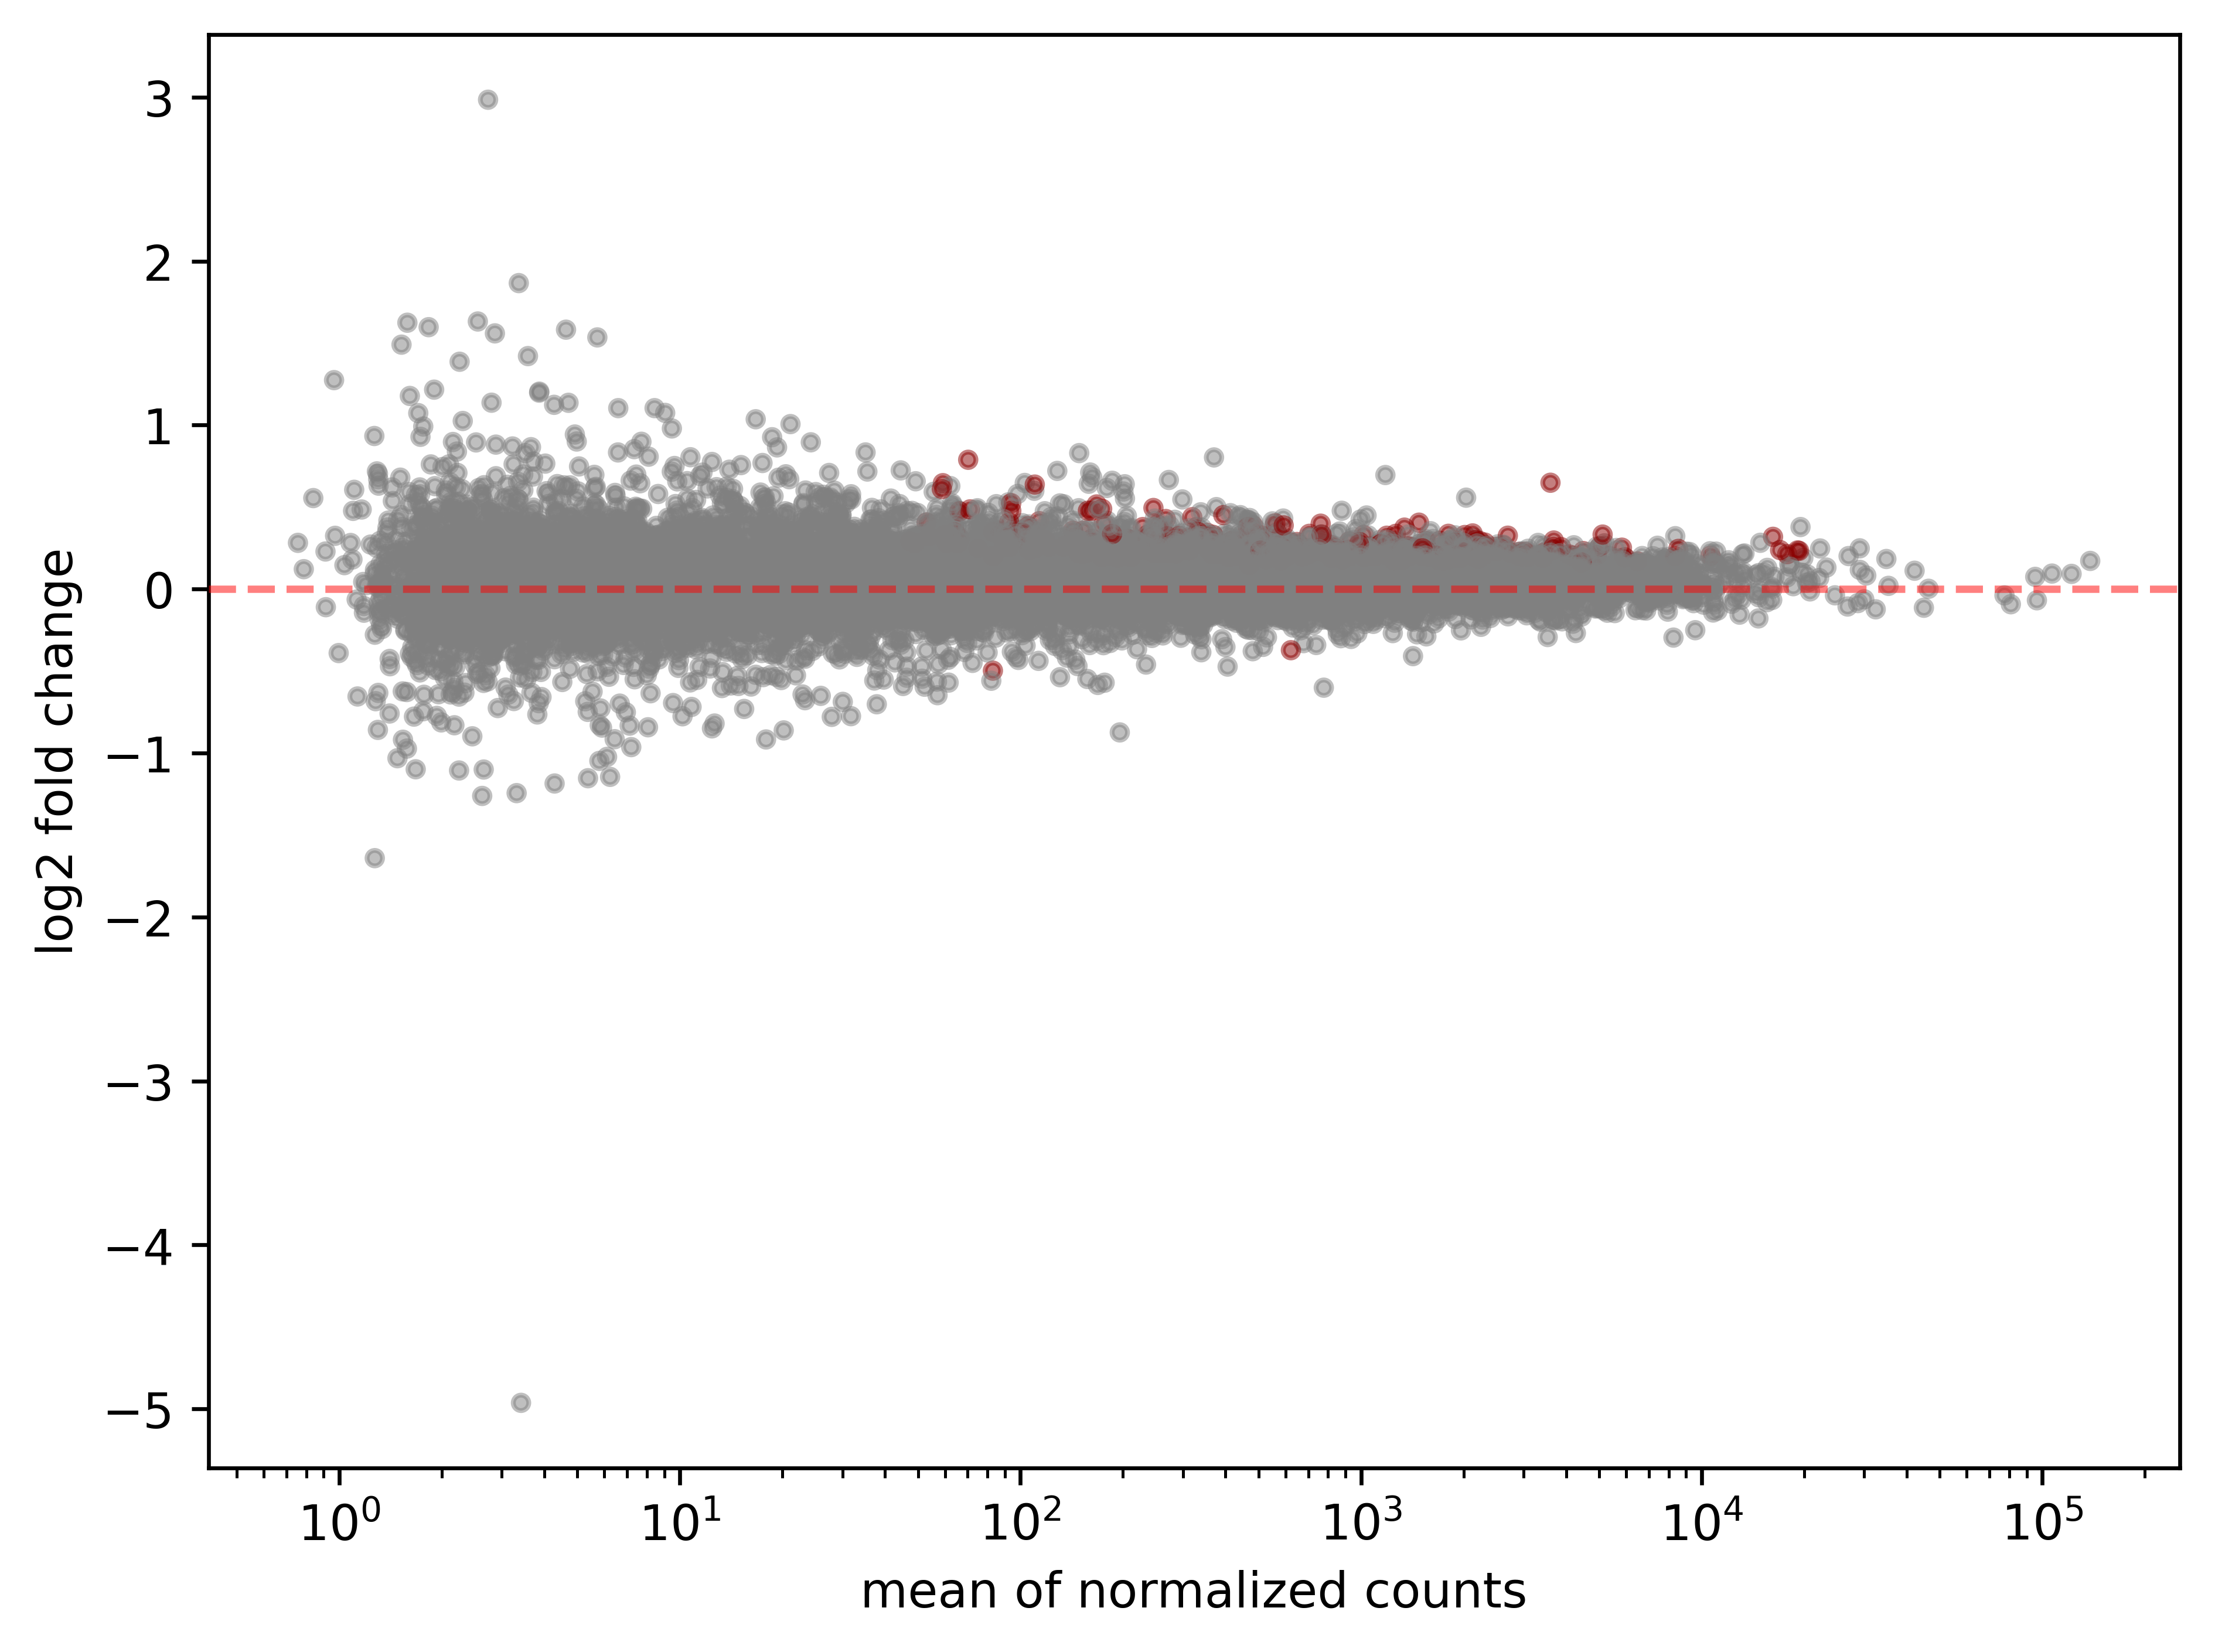

In [19]:
stat_res.plot_MA(s=10)

In [20]:
#LFC shrinkage (apeglm)

stat_res.lfc_shrink(coeff="condition_B_vs_A")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition B vs A
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
g1       499.913326        0.062350  0.068865  1.657220  0.097475  0.470258
g2        65.960276        0.211525  0.130254  2.758086  0.005814  0.108218
g3       126.155981        0.034033  0.081290  1.317340  0.187725  0.605569
g4       379.379273        0.138723  0.062025  2.946943  0.003209  0.077962
g5       397.678162        0.029833  0.094102  1.675426  0.093851  0.464002
...             ...             ...       ...       ...       ...       ...
g14996  7954.309323       -0.200624  0.101167 -1.457684  0.144928  0.549877
g14997     1.694590        0.006290  0.090162  0.985884  0.324190       NaN
g14998    11.203022       -0.027169  0.084091 -1.498927  0.133893       NaN
g14999    29.651196       -0.000716  0.065620 -0.020232  0.983858       NaN
g15000    72.477515        0.015545  0.055160  0.532240  0.594560  0.894351

[15000 rows x 6 columns]


... done in 1.35 seconds.



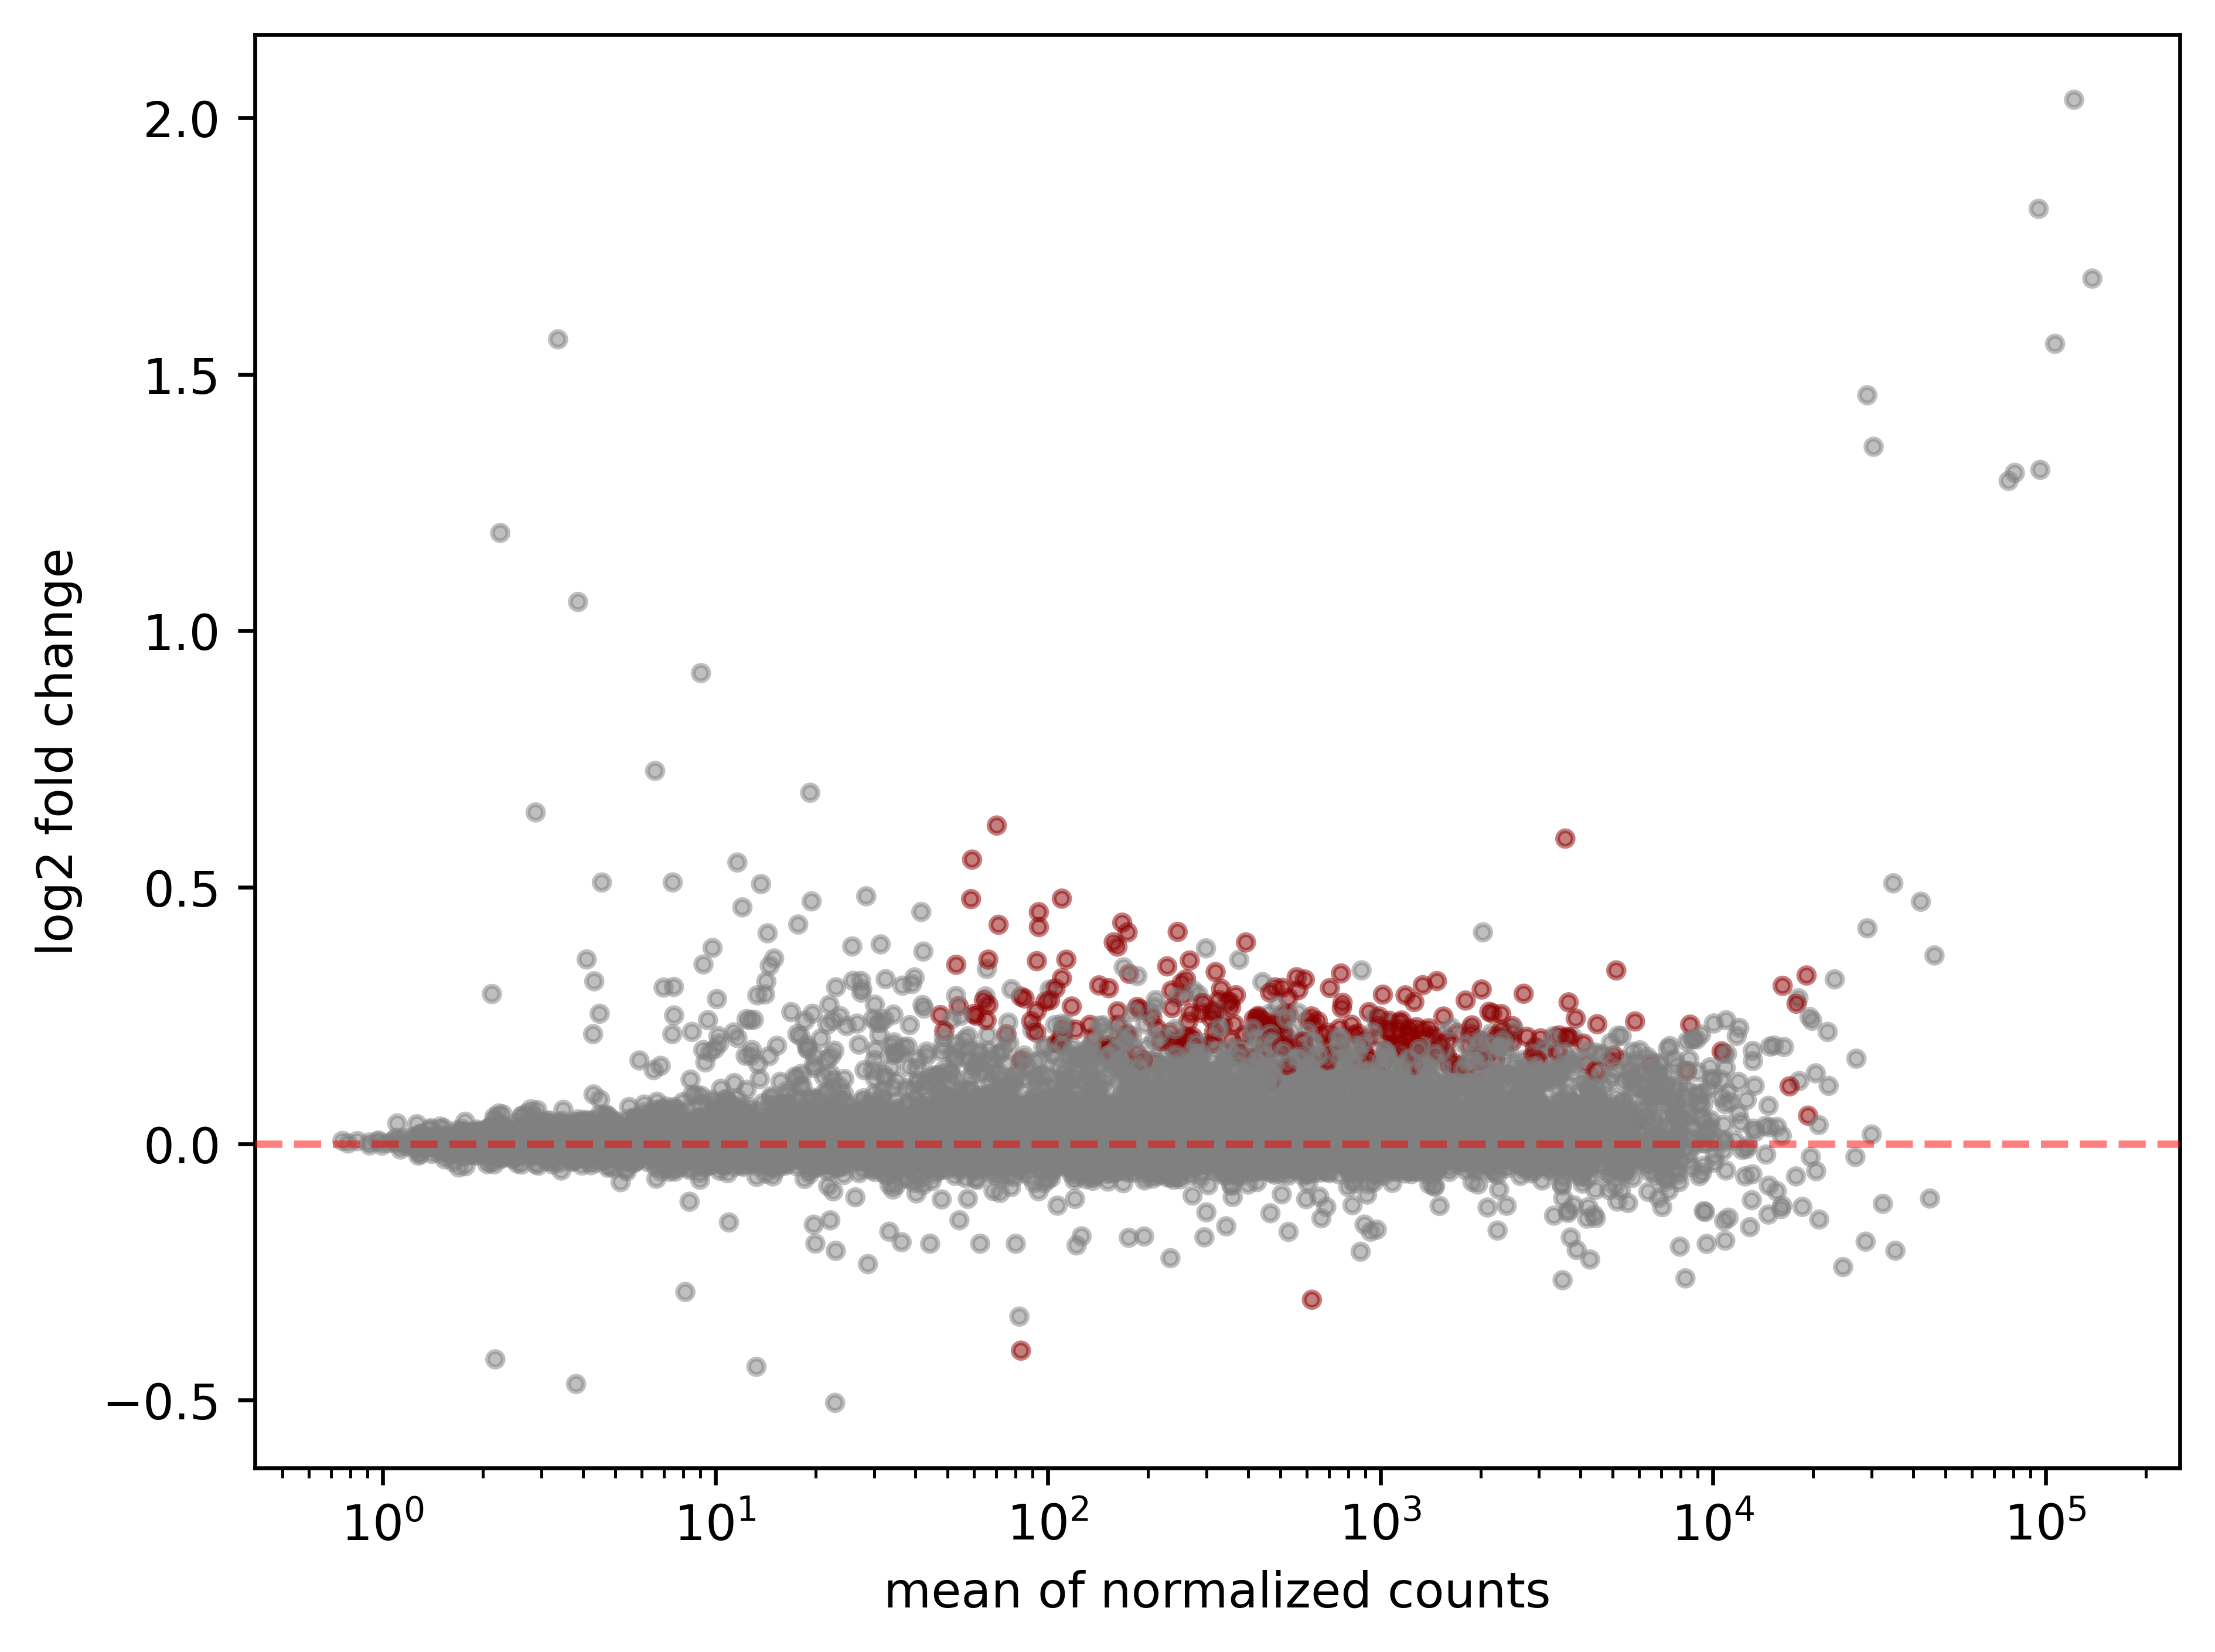

In [21]:
stat_res.plot_MA(s=10)

In [22]:
stat_res.results_df.to_csv(os.path.join(OUTPUT_PATH, "res1_nocnv.csv"))